# Capstone Project - The Battle of Neighborhoods (Week 2)

# 1. Introduction

In this section a description of the problem and a discussion of the background are provided.

## 1.1 Background information

Moving from one place to another is something that is done very frequently in our times and can both be very exciting and challenging. There are many reasons for it, e.g. beginning a new job, studying in another city or moving together with your partner. People often want to find a similar place to the one they lived before, especially when they got used to their former neighborhood and felt very comfortable there. Sometimes they also want to change a few things and put more emphasis on different venues nearby, e.g. a park or a certain kind of shop/restaurant. This problem can be tackled using data science methods.

## 1.2 Problem statement

We are exploring neighbourhoods in the city of Munich, Germany, to find a new apartment for Anna that meets her requirements. Anna is 30 years old and at the moment she is living in the borough 'Maxvorstadt' where she feels very comofortable. However, she is only allowed to stay in her current apartment until the end of the year and there are a few things she does not like about it, e.g. that it is very expensive (19.50 €/m²), has no park nearby and that the surrounding area is a little bit too crowded. As a result she is looking for a new apartment in another neighbourhood that is ideally very similar to Maxvorstadt. In addition, Anna would enjoy to have the following venues nearby:

| Venue | Reason | Priority |
| --- | --- | --- |
| Park | Anna likes to take a walk in the park after work. | 1 |
| Tram Station | Anna requires a tram station nearby to get to work easily.  | 2 |
| German Restaurant | Anna often comes home late from work and has no time to cook on her own. She is very much into German food.  | 3 |
| Thai Restaurant | Anna also likes Thai food.  | 4 |
| Cupcake Shop | Anna loves cupcakes and is thinking about opening her own shop.  | 5 |

We will use data science methods to identify the most promissing neighborhoods based on these criteria.

## 1.3 Target audience

Solving this problem can be interesting for everyone who is moving to another city, not exclusively for Anna. The method can be easily transferred to other cities and different people with different needs and preferences. It would also be possible for real estate agents to use similar algorithms to find the perfect home for their customers.

# 2. Data

In this section a description of the data and how it will be used to solve the problem is provided.

## 2.1 Data description

In order to find the most promising neighborhood for Anna the following data is needed:
* A list of existing boroughs in Munich, including additional information like Area in km² and Inhabitants per km². This data is gathered through web scraping from the following webpage: 'https://en.wikipedia.org/wiki/Population_growth_of_Munich#Age_distribution'.
* Geospatial data (latitude, longitude) for each borough. This data is gathered using the Geocoder API based on Open Street Map data and is used as an input for the Foursquare API.
* Average rental prices for all boroughs in Munich. This data is gathered through web scraping from the following webpage: 'https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html'. To work with this data, the postal codes need to be attributed to the corresponding borough via 'https://www.muenchen.de/leben/service/postleitzahlen.html'.
* Information about nearby venues for all boroughs of Munich. This data is gathered using the Foursquare API.

## 2.2 Data usage

We will start by preparing the data from the websites so that we have one overview table that contains all the information (borough, longitude, latitude, rental price, inhabitants per km²) we need. In a next step we peform an exploratory data analysis (using the describe method and a histogram plot) to get insights in the average rental prices for different boroughs in Munich, to which we can compare Anna's current rent and the average rent in her current borough, Maxvorstadt. The data is visualized in a Folium map.

We will prepare a second table using Foursquare data, which contains the top 100 venues within a radius of 1.5 km for each borough. We use one hot encoding to get the 10 most common venues for each borough. Clustering the neighborhood with k-means will limit the boroughs to the ones that are similar to Maxvorstadt (e.g. are in the same cluster).

Using the data from the first table we will limit our further analyis to boroughs where the rent is cheaper than Anna's current rent and which are less crowded (inhabitants per km²) than Maxvorstadt.

Finally we will visualize Anna's favourite venues color coded on the map and count their occurence within the list of top 100 venues of each borough. Combining our results gives us the possibility to recommend the best borough for Anna.

## 2.3 Data preparation

The data is prepared like described below.

### 2.3.1 Import Python libraries

In [364]:
# import libraries
import pandas as pd
import numpy as np
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import itertools
print('Libraries imported.')

Libraries imported.


### 2.3.2 Get a list of existing boroughs in Munich, Germany

In [365]:
# read Wikipedia data into pd dataframe
df_nb = pd.read_html('https://en.wikipedia.org/wiki/Population_growth_of_Munich#Age_distribution')[16]

In [366]:
# cleanse data and show dataframe
df_nb = df_nb[0:25]
df_nb.rename(columns={"Name":"Borough"}, inplace=True)
df_nb["Longitude"] = np.nan
df_nb["Latitude"] = np.nan
df_nb.head(10)

,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude
0,Allach-Untermenzing,15.45,27730,1795,NaN,NaN
1,Altstadt-Lehel,3.16,18876,5973,NaN,NaN
2,Aubing-Lochhausen-Langwied,34.06,37857,1111,NaN,NaN
3,Au-Haidhausen,4.22,54382,12887,NaN,NaN
4,Berg am Laim,6.31,39009,6182,NaN,NaN
5,Bogenhausen,23.71,75657,3191,NaN,NaN
6,Feldmoching-Hasenbergl,28.71,54245,1889,NaN,NaN
7,Hadern,9.23,44993,4875,NaN,NaN
8,Laim,5.29,50082,9457,NaN,NaN
9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,NaN,NaN


In [367]:
# print number of boroughs
df_nb.shape

(25, 6)

We now have a datset containing the 25 boroughs of Munich. It also includes additional information like the number of inhabitants per km² to judge whether a borough is less crowded than Maxvorstadt.

### 2.3.3 Add coordinates to each borough (using Geocoder API)

In [368]:
# import geocoder
import geocoder
# test geocoder
g = geocoder.osm('Munich')
print(g.x)
print(g.y)

11.5753822
48.1371079


#### Define function to get coordinates

In [369]:
# define function
def geocoding(mnb):
    # initialize variable to None
    latitude = None
    longitude = None
    # loop until getting the coordinates
    while(latitude is None):
        g = geocoder.osm('München ' + mnb)
        latitude = g.x
        longitude = g.y
    df_nb.loc[i, "Longitude"] = latitude
    df_nb.loc[i, "Latitude"] = longitude

#### Loop through boroughs and append coordinates

In [370]:
# loop through neighborhoods and append coordinates to df
l = len(df_nb["Borough"])
for i in range(0, l):
    geocoding(df_nb["Borough"][i])

#### Show resulting dataframe

In [371]:
# show first ten rows
df_nb.head(10)

,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude
0,Allach-Untermenzing,15.45,27730,1795,11.462973,48.195157
1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828
2,Aubing-Lochhausen-Langwied,34.06,37857,1111,11.400221,48.165059
3,Au-Haidhausen,4.22,54382,12887,11.590536,48.128753
4,Berg am Laim,6.31,39009,6182,11.633600,48.133971
5,Bogenhausen,23.71,75657,3191,11.633484,48.154782
6,Feldmoching-Hasenbergl,28.71,54245,1889,11.541275,48.213804
7,Hadern,9.23,44993,4875,11.481842,48.118064
8,Laim,5.29,50082,9457,11.503835,48.144352
9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340


### 2.3.4 Add rental price per squaremeter for each borough

#### First step: Get boroughs of Munich and corresponding postal code

In [372]:
# get postal codes from web
url = 'https://www.muenchen.de/leben/service/postleitzahlen.html'
df_munichPoctcode = pd.read_html(url, header=0)[0]
df_munichPoctcode.rename(columns={'Stadtteil':'Borough', 'Postleitzahl':'PostalCode'}, inplace = True)
df_munichPoctcode.head()

,Borough,PostalCode
0,Allach-Untermenzing,"80995, 80997, 80999, 81247, 81249"
1,Altstadt-Lehel,"80331, 80333, 80335, 80336, 80469, 80538, 80539"
2,Au-Haidhausen,"81541, 81543, 81667, 81669, 81671, 81675, 81677"
3,Aubing-Lochhausen-Langwied,"81243, 81245, 81249"
4,Berg am Laim,"81671, 81673, 81735, 81825"


In [373]:
# Save all boroughs in a list
borough_list = df_munichPoctcode['Borough'].to_list()
borough_list = list(itertools.chain.from_iterable(itertools.repeat(x, 9) for x in borough_list))

# Save all postal codes in a list
df_postal = df_munichPoctcode[['PostalCode']].PostalCode.str.split(",",expand=True)
postalcode_list = []

count = 0
# Copy all postal codes in one column under each other
for element in (range(0,len(df_postal))):
    postalcode_list.extend(df_postal.iloc[count])
    count+=1
postalcode_list

# Combine borough and postal code list in new dataframe 
df_postalcodes = pd.DataFrame(list(zip(borough_list, postalcode_list)), columns =['Borough', 'PostalCode']) 
df_postalcodes.head(20)

# Drop columns that contain NaNs
df_postalcodes.dropna(inplace = True)
df_postalcodes.reset_index(drop=True, inplace=True)
df_postalcodes.head(10)

,Borough,PostalCode
0,Allach-Untermenzing,80995
1,Allach-Untermenzing,80997
2,Allach-Untermenzing,80999
3,Allach-Untermenzing,81247
4,Allach-Untermenzing,81249
5,Altstadt-Lehel,80331
6,Altstadt-Lehel,80333
7,Altstadt-Lehel,80335
8,Altstadt-Lehel,80336
9,Altstadt-Lehel,80469


#### Second step: Get rental prices for boroughs and merge data

In [374]:
# get rental prices from web
df_rent1 = pd.read_html('https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html', header=None)[0]
df_rent2 = pd.read_html('https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html', header=None)[1]
df_rent3 = pd.read_html('https://www.tz.de/leben/wohnen/uebersicht-muenchner-mieten-preise-nach-postleitzahlen-tz-6133643.html', header=None)[2]
df_rent = pd.concat([df_rent1, df_rent2, df_rent3])
df_rent = df_rent[1:]
df_rent.rename(columns={0:"PostalCode", 1:"Rental price", 2:"Rental trend", 3:"Buy price", 4:"Buy trend"}, inplace = True)
df_rent.dropna(inplace=True)
df_rent.head(10)

,PostalCode,Rental price,Rental trend,Buy price,Buy trend
2,80995,1410,"1,1%",5000,"6,8%"
3,80997,1325,"-1,9%",5430,"12,4%"
4,80999,1305,"5,2%",5880,"11,4%"
5,81247,1455,"2,5%",6520,"1,4%"
6,81249,1325,"5,6%",5100,"3,4%"
8,80331,2230,"3,5%",k.A.,k.A.
9,80333,1910,"1,9%",9120,"20,8%"
10,80335,1955,"2,9%",8690,"5,8%"
11,80336,1815,"0,0%",8960,"9,0%"
12,80469,206,"4,8%",8370,"0,5%"


In [375]:
# merge dataframes
df_postalcodes["PostalCode"] = df_postalcodes["PostalCode"].astype(int) 
df_rent["PostalCode"] = df_rent["PostalCode"].astype(int) 
df_rent.set_index(['PostalCode'], inplace = True)
df_postalcodes.set_index(['PostalCode'],inplace = True)

In [376]:
# join dataframes
df_rental_prices = df_postalcodes.join(df_rent)
df_rental_prices.reset_index(inplace = True)
df_rental_prices = df_rental_prices[["Borough", "Rental price"]]
df_rental_prices["Rental price"] = df_rental_prices["Rental price"].apply(pd.to_numeric, errors='coerce')
df_rental_prices.dropna(inplace = True)

# group values based on their borough and calculate mean price
df_rental_prices_grouped = df_rental_prices.groupby('Borough').mean()
df_rental_prices_grouped.head(10)

,Rental price
Borough,
Allach-Untermenzing,1370.555556
Altstadt-Lehel,1877.555556
Au-Haidhausen,1708.571429
Aubing-Lochhausen-Langwied,1378.333333
Berg am Laim,1478.750000
Bogenhausen,1729.375000
Feldmoching-Hasenbergl,1401.250000
Hadern,1456.666667
Laim,1521.428571


In [377]:
# cleanse data and add it to merged dataframe
k = len(df_nb)
df_nb["Rent per m²"] = np.nan
for i in range(0,k):
    df_nb.loc[i, "Rent per m²"] = (df_rental_prices_grouped["Rental price"][i]/100).round(2)
df_nb

,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude,Rent per m²
0,Allach-Untermenzing,15.45,27730,1795,11.462973,48.195157,13.71
1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828,18.78
2,Aubing-Lochhausen-Langwied,34.06,37857,1111,11.400221,48.165059,17.09
3,Au-Haidhausen,4.22,54382,12887,11.590536,48.128753,13.78
4,Berg am Laim,6.31,39009,6182,11.633600,48.133971,14.79
5,Bogenhausen,23.71,75657,3191,11.633484,48.154782,17.29
6,Feldmoching-Hasenbergl,28.71,54245,1889,11.541275,48.213804,14.01
7,Hadern,9.23,44993,4875,11.481842,48.118064,14.57
8,Laim,5.29,50082,9457,11.503835,48.144352,15.21
9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340,17.84


The dataframe 'df_nb' now contains all the necessary information for each borough, including name, area, inhabitants, longitude, latitude and average rent.

### 2.3.5 Using Foursquare to explore the area around the boroughs

#### Use geopy library to get the latitude and longitude values of Munich:

In [378]:
address = 'Munich'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich, Germany are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Munich, Germany are 48.1371079, 11.5753822.


#### Define Foursquare credentials and version

In [379]:
CLIENT_ID = 'BYC11MLYZJFKLNFDVQZL34Y4RONJ5BPR4RWOC0MV00JRUWOM' # your Foursquare ID
CLIENT_SECRET = '21XP2WR2WDQGN4TQY4VFTYSL5CVO53AI45B34CBUA1X1X2JM' # your Foursquare Secret
VERSION = '20201212' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BYC11MLYZJFKLNFDVQZL34Y4RONJ5BPR4RWOC0MV00JRUWOM
CLIENT_SECRET:21XP2WR2WDQGN4TQY4VFTYSL5CVO53AI45B34CBUA1X1X2JM


#### Create a function to find the top 100 venues within 1.5 km radius for each borough

In [380]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on all boroughs

In [381]:
munich_venues = getNearbyVenues(names=df_nb['Borough'],
                                   latitudes=df_nb['Latitude'],
                                   longitudes=df_nb['Longitude']
                                  )

Allach-Untermenzing
Altstadt-Lehel
Aubing-Lochhausen-Langwied
Au-Haidhausen
Berg am Laim
Bogenhausen
Feldmoching-Hasenbergl
Hadern
Laim
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Milbertshofen-Am Hart
Moosach
Neuhausen-Nymphenburg
Obergiesing
Pasing-Obermenzing
Ramersdorf-Perlach
Schwabing-Freimann
Schwabing-West
Schwanthalerhöhe
Sendling
Sendling-Westpark
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
Trudering-Riem
Untergiesing-Harlaching


In [382]:
print(str(munich_venues.shape[0]) + " venues found.")
munich_venues.head(5)

1845 venues found.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allach-Untermenzing,48.195157,11.462973,Bäckerei Schuhmair,48.197175,11.459016,Bakery
1,Allach-Untermenzing,48.195157,11.462973,Sport Bittl,48.191447,11.466553,Sporting Goods Shop
2,Allach-Untermenzing,48.195157,11.462973,Trattoria Olive,48.189905,11.466970,Trattoria/Osteria
3,Allach-Untermenzing,48.195157,11.462973,Zur Allacher Mühle,48.198411,11.457869,Bavarian Restaurant
4,Allach-Untermenzing,48.195157,11.462973,Würmtalhof,48.188834,11.460680,German Restaurant


The dataframe 'munich_venues' now contains the top 100 venues of all boroughs in Munich.

In [383]:
# show how many vanues were found for each borough
munich_venues.groupby('Neighborhood')["Venue"].count()

Neighborhood
Allach-Untermenzing                                        21
Altstadt-Lehel                                            100
Au-Haidhausen                                             100
Aubing-Lochhausen-Langwied                                 12
Berg am Laim                                               70
Bogenhausen                                                98
Feldmoching-Hasenbergl                                     21
Hadern                                                     41
Laim                                                       91
Ludwigsvorstadt-Isarvorstadt                              100
Maxvorstadt                                               100
Milbertshofen-Am Hart                                     100
Moosach                                                    54
Neuhausen-Nymphenburg                                      99
Obergiesing                                               100
Pasing-Obermenzing                                       

In [384]:
print('There are {} unique venue categories.'.format(len(munich_venues['Venue Category'].unique())))

There are 224 unique venue categories.


## 2.4 Summary of datasets

Further data analysis can be performed on the two data sets resulting from our data preparation: 
* 'df_nb' (borough, area, inhabitants, longitude, latitude, rent)
* 'munich_venues' (top 100 venues in each of the borough within a radius of 1.5 km).

# 3. Methodology

This section represents the main component of the report.

## 3.1 Exploratory Data Analysis

As mentioned in the previous section, we have the two following datasets that can be used to solve the question, which borough is the best one for Anna's new apartment:
* The dataframe 'df_nb' is used to find a borough which is less crowded than Maxvorstadt and where the average rental price is less than what Anna is paying now (19.50 €/m²).
* The dataframe 'munich_venues' is used to explore and cluster neighborhoods, inclduing venues of interest nearby that meet Anna's expectations.

### 3.1.1 Exploring boroughs of Munich and show them on map

#### Use geopy library to get the latitude and longitude values of Munich.

In [385]:
address = 'Munich'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich, Germany are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Munich, Germany are 48.1371079, 11.5753822.


#### Create a map of Munich with neighborhoods superimposed on top.

In [386]:
# create map of Munich using latitude and longitude values
map_munich = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_nb['Latitude'], df_nb['Longitude'], df_nb['Borough']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)  
    
map_munich

## 3.2 Analyze Foursquare dataset via one hot encoding

In [387]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Neighborhood'] = munich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allach-Untermenzing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [388]:
print(str(munich_onehot.shape[0]) + " venues found.")

1845 venues found.


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [389]:
munich_grouped = munich_onehot.groupby('Neighborhood').mean().reset_index()
munich_grouped.head(10)

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Allach-Untermenzing,0.000000,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.000000,0.095238,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.000000
1,Altstadt-Lehel,0.000000,0.00,0.000000,0.0,0.00,0.01,0.000000,0.000000,0.0,...,0.000000,0.010000,0.000000,0.0,0.01,0.00,0.000000,0.01,0.0,0.010000
2,Au-Haidhausen,0.000000,0.02,0.000000,0.0,0.01,0.00,0.000000,0.000000,0.0,...,0.000000,0.010000,0.000000,0.0,0.01,0.00,0.000000,0.01,0.0,0.010000
3,Aubing-Lochhausen-Langwied,0.000000,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.000000
4,Berg am Laim,0.014286,0.00,0.000000,0.0,0.00,0.00,0.028571,0.000000,0.0,...,0.042857,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.000000
5,Bogenhausen,0.000000,0.00,0.000000,0.0,0.00,0.00,0.040816,0.020408,0.0,...,0.020408,0.010204,0.010204,0.0,0.00,0.00,0.010204,0.00,0.0,0.000000
6,Feldmoching-Hasenbergl,0.000000,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.000000
7,Hadern,0.000000,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.024390,0.024390,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.000000
8,Laim,0.000000,0.00,0.010989,0.0,0.00,0.00,0.000000,0.010989,0.0,...,0.021978,0.010989,0.000000,0.0,0.00,0.00,0.000000,0.00,0.0,0.010989
9,Ludwigsvorstadt-Isarvorstadt,0.000000,0.02,0.000000,0.0,0.01,0.00,0.010000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.01,0.02,0.000000,0.01,0.0,0.010000


#### Find top 10 most common venues for each borough and store them in a dataframe

In [390]:
num_top_venues = 10

for hood in munich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
                 venue  freq
0                Hotel  0.14
1        Shopping Mall  0.10
2               Bakery  0.10
3  Bavarian Restaurant  0.10
4    Trattoria/Osteria  0.10
5            Drugstore  0.10
6          Supermarket  0.10
7    German Restaurant  0.05
8  Sporting Goods Shop  0.05
9                 Park  0.05


----Altstadt-Lehel----
                 venue  freq
0                Plaza  0.09
1                 Café  0.07
2                Hotel  0.05
3  Bavarian Restaurant  0.05
4          Coffee Shop  0.05
5    German Restaurant  0.05
6           Restaurant  0.04
7         Gourmet Shop  0.03
8         Cocktail Bar  0.03
9     Department Store  0.03


----Au-Haidhausen----
                 venue  freq
0                 Café  0.08
1                Plaza  0.07
2    German Restaurant  0.06
3                Hotel  0.05
4          Coffee Shop  0.04
5  Bavarian Restaurant  0.04
6                  Pub  0.03
7          Beer Garden  0.03
8    Indian Restaurant  

#### Put data into pd dataframe.

In [391]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [392]:
# create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = munich_grouped['Neighborhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,Hotel,Drugstore,Bavarian Restaurant,Supermarket,Bakery,Shopping Mall,Trattoria/Osteria,Italian Restaurant,Light Rail Station,German Restaurant
1,Altstadt-Lehel,Plaza,Café,Bavarian Restaurant,German Restaurant,Hotel,Coffee Shop,Restaurant,Gourmet Shop,Department Store,Cocktail Bar
2,Au-Haidhausen,Café,Plaza,German Restaurant,Hotel,Coffee Shop,Bavarian Restaurant,Pub,Beer Garden,Cocktail Bar,Beach
3,Aubing-Lochhausen-Langwied,Soccer Field,Bus Stop,Bakery,Bistro,Supermarket,Light Rail Station,German Restaurant,Hotel,Post Office,Pharmacy
4,Berg am Laim,Hotel,Italian Restaurant,Supermarket,Bakery,Drugstore,Tram Station,German Restaurant,Asian Restaurant,Gym,Gastropub
5,Bogenhausen,Italian Restaurant,Bus Stop,Supermarket,Drugstore,Hotel,Bakery,Asian Restaurant,Beer Garden,German Restaurant,Plaza
6,Feldmoching-Hasenbergl,Supermarket,Plaza,Drugstore,Bakery,Italian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Intersection,Café
7,Hadern,Supermarket,Bus Stop,Bakery,Bank,German Restaurant,Drugstore,Ice Cream Shop,Sushi Restaurant,Residential Building (Apartment / Condo),Sandwich Place
8,Laim,Supermarket,Greek Restaurant,Plaza,Italian Restaurant,Drugstore,Pizza Place,Bakery,Hotel,Park,Gastropub
9,Ludwigsvorstadt-Isarvorstadt,Café,Coffee Shop,Italian Restaurant,Bavarian Restaurant,German Restaurant,Plaza,Cocktail Bar,Ice Cream Shop,Pizza Place,Bookstore


## 3.3 Cluster neighborhoods

#### Run k-means to cluster the neighborhood into 5 clusters.

In [393]:
# set number of clusters
kclusters = 5

munich_grouped_clustering = munich_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 0, 2, 3, 3, 1, 1, 3, 0])

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [394]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

munich_merged = df_nb

# merge munich_grouped with munich_data to add latitude/longitude for each neighborhood
munich_merged = munich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Borough')

munich_merged.dropna(inplace = True)
munich_merged.head(10)

,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allach-Untermenzing,15.45,27730,1795,11.462973,48.195157,13.71,4,Hotel,Drugstore,Bavarian Restaurant,Supermarket,Bakery,Shopping Mall,Trattoria/Osteria,Italian Restaurant,Light Rail Station,German Restaurant
1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828,18.78,0,Plaza,Café,Bavarian Restaurant,German Restaurant,Hotel,Coffee Shop,Restaurant,Gourmet Shop,Department Store,Cocktail Bar
2,Aubing-Lochhausen-Langwied,34.06,37857,1111,11.400221,48.165059,17.09,2,Soccer Field,Bus Stop,Bakery,Bistro,Supermarket,Light Rail Station,German Restaurant,Hotel,Post Office,Pharmacy
3,Au-Haidhausen,4.22,54382,12887,11.590536,48.128753,13.78,0,Café,Plaza,German Restaurant,Hotel,Coffee Shop,Bavarian Restaurant,Pub,Beer Garden,Cocktail Bar,Beach
4,Berg am Laim,6.31,39009,6182,11.633600,48.133971,14.79,3,Hotel,Italian Restaurant,Supermarket,Bakery,Drugstore,Tram Station,German Restaurant,Asian Restaurant,Gym,Gastropub
5,Bogenhausen,23.71,75657,3191,11.633484,48.154782,17.29,3,Italian Restaurant,Bus Stop,Supermarket,Drugstore,Hotel,Bakery,Asian Restaurant,Beer Garden,German Restaurant,Plaza
6,Feldmoching-Hasenbergl,28.71,54245,1889,11.541275,48.213804,14.01,1,Supermarket,Plaza,Drugstore,Bakery,Italian Restaurant,Gastropub,German Restaurant,Greek Restaurant,Intersection,Café
7,Hadern,9.23,44993,4875,11.481842,48.118064,14.57,1,Supermarket,Bus Stop,Bakery,Bank,German Restaurant,Drugstore,Ice Cream Shop,Sushi Restaurant,Residential Building (Apartment / Condo),Sandwich Place
8,Laim,5.29,50082,9457,11.503835,48.144352,15.21,3,Supermarket,Greek Restaurant,Plaza,Italian Restaurant,Drugstore,Pizza Place,Bakery,Hotel,Park,Gastropub
9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340,17.84,0,Café,Coffee Shop,Italian Restaurant,Bavarian Restaurant,German Restaurant,Plaza,Cocktail Bar,Ice Cream Shop,Pizza Place,Bookstore


#### Visualize the resulting clusters

In [395]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(munich_merged['Latitude'], munich_merged['Longitude'], munich_merged['Borough'], munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine clusters

In [396]:
munich_merged.loc[munich_merged['Cluster Labels'] == 0, munich_merged.columns[[0] + list(range(3, 7)) + [7] + list(range(8, 13))]]

,Borough,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Altstadt-Lehel,5973,11.574582,48.137828,18.78,0,Plaza,Café,Bavarian Restaurant,German Restaurant,Hotel
3,Au-Haidhausen,12887,11.590536,48.128753,13.78,0,Café,Plaza,German Restaurant,Hotel,Coffee Shop
9,Ludwigsvorstadt-Isarvorstadt,10418,11.573366,48.130340,17.84,0,Café,Coffee Shop,Italian Restaurant,Bavarian Restaurant,German Restaurant
10,Maxvorstadt,10736,11.562418,48.151092,19.98,0,Café,Plaza,Bakery,Vietnamese Restaurant,Bar
11,Milbertshofen-Am Hart,5011,11.575043,48.182385,14.73,0,Hotel,Italian Restaurant,Bakery,Drugstore,Greek Restaurant
13,Neuhausen-Nymphenburg,6548,11.531517,48.154222,16.44,0,Italian Restaurant,Café,Plaza,German Restaurant,Hotel
18,Schwabing-West,13628,11.569873,48.168271,19.27,0,Italian Restaurant,Greek Restaurant,Restaurant,Vietnamese Restaurant,Plaza
19,Schwanthalerhöhe,12610,11.541057,48.133782,18.97,0,Café,Hotel,Asian Restaurant,Italian Restaurant,Bavarian Restaurant
24,Untergiesing-Harlaching,5965,11.570189,48.114963,15.50,0,Italian Restaurant,Café,German Restaurant,Bar,Greek Restaurant


The boroughs with cluster label 0 are similar to Maxvorstadt and are therefore preferred by Anna.

In [397]:
munich_merged.loc[munich_merged['Cluster Labels'] == 1, munich_merged.columns[[0] + list(range(3, 7)) + [7] + list(range(8, 13))]]

,Borough,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Feldmoching-Hasenbergl,1889,11.541275,48.213804,14.01,1,Supermarket,Plaza,Drugstore,Bakery,Italian Restaurant
7,Hadern,4875,11.481842,48.118064,14.57,1,Supermarket,Bus Stop,Bakery,Bank,German Restaurant
12,Moosach,4306,11.506122,48.180166,15.11,1,Supermarket,Bakery,Drugstore,Hotel,Bus Stop
23,Trudering-Riem,2401,11.663338,48.126036,14.78,1,Supermarket,Hotel,Drugstore,Bakery,German Restaurant


In [398]:
munich_merged.loc[munich_merged['Cluster Labels'] == 2, munich_merged.columns[[0] + list(range(3, 7)) + [7] + list(range(8, 13))]]

,Borough,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Aubing-Lochhausen-Langwied,1111,11.400221,48.165059,17.09,2,Soccer Field,Bus Stop,Bakery,Bistro,Supermarket


In [399]:
munich_merged.loc[munich_merged['Cluster Labels'] == 3, munich_merged.columns[[0] + list(range(3, 7)) + [7] + list(range(8, 13))]]

,Borough,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Berg am Laim,6182,11.633600,48.133971,14.79,3,Hotel,Italian Restaurant,Supermarket,Bakery,Drugstore
5,Bogenhausen,3191,11.633484,48.154782,17.29,3,Italian Restaurant,Bus Stop,Supermarket,Drugstore,Hotel
8,Laim,9457,11.503835,48.144352,15.21,3,Supermarket,Greek Restaurant,Plaza,Italian Restaurant,Drugstore
14,Obergiesing,8232,11.596084,48.111130,15.78,3,Supermarket,Greek Restaurant,German Restaurant,Drugstore,Italian Restaurant
15,Pasing-Obermenzing,3864,11.461767,48.149956,14.46,3,Supermarket,German Restaurant,Drugstore,Italian Restaurant,Ice Cream Shop
16,Ramersdorf-Perlach,5160,11.633371,48.100894,15.17,3,Supermarket,Bakery,Clothing Store,German Restaurant,Ice Cream Shop
17,Schwabing-Freimann,2432,11.608583,48.189278,18.66,3,Supermarket,Gym / Fitness Center,Fast Food Restaurant,Greek Restaurant,Asian Restaurant
20,Sendling,9428,11.512817,48.124588,16.14,3,Bakery,Bus Stop,Supermarket,Greek Restaurant,German Restaurant
21,Sendling-Westpark,6518,11.519333,48.118031,15.18,3,Supermarket,Hotel,Bakery,Drugstore,Greek Restaurant
22,Thalkirchen-Obersendling-Forstenried-Fürstenri...,4547,11.508051,48.084213,14.43,3,Supermarket,Hotel,Gym / Fitness Center,Drugstore,German Restaurant


In [400]:
munich_merged.loc[munich_merged['Cluster Labels'] == 4, munich_merged.columns[[0] + list(range(3, 7)) + [7] + list(range(8, 13))]]

,Borough,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allach-Untermenzing,1795,11.462973,48.195157,13.71,4,Hotel,Drugstore,Bavarian Restaurant,Supermarket,Bakery


## 3.4 Find a borough where the average rental price is less than what Anna is paying now

In [401]:
# statistics
df_nb.describe()["Rent per m²"].to_frame()

,Rent per m²
count,25.000000
mean,16.066800
std,1.883624
min,13.710000
25%,14.730000
50%,15.210000
75%,17.290000
max,19.980000


The average rent in Munich is (16.07 +/- 1.88) €/m².

In [402]:
print("The average rent in " + str(df_nb.loc[10, "Borough"]) + " is " + str(df_nb.loc[10, "Rent per m²"]) + " €/m².")

The average rent in Maxvorstadt is 19.98 €/m².


#### Visualize distribution of rental prices

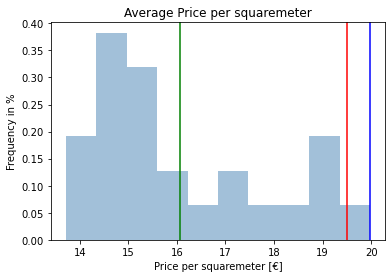

In [403]:
# plot data
plt.ylabel('Frequency in %')
plt.xlabel('Price per squaremeter [€]')
plt.title('Average Price per squaremeter')

plt.hist(df_nb['Rent per m²'], bins=10, density=True, alpha=0.5, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.axvline(19.50, 0,1, color='red')
plt.axvline(19.98, 0,1, color='blue')
plt.axvline(16.07, 0,1, color='green')

Anna's rent (19.50 €/m², red line) is slightly below the average rental price in Maxvorstadt (19.98 €/m², blue line) but still very expensive compared with the average rental price in Munich (16.07 €/m², green line).

#### Visualize rental prices on map

In [404]:
# Create the ranges and colors for different pricing
df_nb['color'] = pd.cut(df_nb['Rent per m²'], bins=4, 
                              labels=['blue','green','orange', 'red'])
histprice = pd.cut(df_nb['Rent per m²'], bins=4).value_counts().to_frame()
histprice.head()

,Rent per m²
"(13.704, 15.278]",13
"(18.412, 19.98]",5
"(15.278, 16.845]",4
"(16.845, 18.412]",3


In [405]:
# create map
map_prices = folium.Map(location=[latitude, longitude], zoom_start=11)

#add circles in the colors associated with the defined range
for index, row in df_nb.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         popup=row['Borough'],
                         color=row['color'], 
                         fill=True,
                         fill_color=row['color'],
                         fill_opacity=0.8
                       ).add_to(map_prices)

map_prices

The map shows that most expensive boroughs (red circles) including Maxvorstadt are located close to the city center whereas rental prices in the outskirts (blue circles) are cheaper on average.

## 3.5 Find borough with average rental price smaller than current rent within cluster 0

In [406]:
munich_fav = munich_merged[munich_merged["Cluster Labels"] == 0]
# Rent must be cheaper
munich_fav = munich_fav[munich_fav["Rent per m²"] < 19.50]
munich_fav

,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828,18.78,0,Plaza,Café,Bavarian Restaurant,German Restaurant,Hotel,Coffee Shop,Restaurant,Gourmet Shop,Department Store,Cocktail Bar
3,Au-Haidhausen,4.22,54382,12887,11.590536,48.128753,13.78,0,Café,Plaza,German Restaurant,Hotel,Coffee Shop,Bavarian Restaurant,Pub,Beer Garden,Cocktail Bar,Beach
9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340,17.84,0,Café,Coffee Shop,Italian Restaurant,Bavarian Restaurant,German Restaurant,Plaza,Cocktail Bar,Ice Cream Shop,Pizza Place,Bookstore
11,Milbertshofen-Am Hart,13.37,66992,5011,11.575043,48.182385,14.73,0,Hotel,Italian Restaurant,Bakery,Drugstore,Greek Restaurant,Supermarket,Café,Gastropub,Restaurant,Museum
13,Neuhausen-Nymphenburg,12.92,84604,6548,11.531517,48.154222,16.44,0,Italian Restaurant,Café,Plaza,German Restaurant,Hotel,Supermarket,Drugstore,Greek Restaurant,Sushi Restaurant,Restaurant
18,Schwabing-West,4.37,59553,13628,11.569873,48.168271,19.27,0,Italian Restaurant,Greek Restaurant,Restaurant,Vietnamese Restaurant,Plaza,Thai Restaurant,Bakery,Park,Asian Restaurant,Museum
19,Schwanthalerhöhe,2.07,26103,12610,11.541057,48.133782,18.97,0,Café,Hotel,Asian Restaurant,Italian Restaurant,Bavarian Restaurant,German Restaurant,Vietnamese Restaurant,Music Venue,Bistro,Lounge
24,Untergiesing-Harlaching,8.06,48075,5965,11.570189,48.114963,15.50,0,Italian Restaurant,Café,German Restaurant,Bar,Greek Restaurant,Park,Ice Cream Shop,Pub,Beach,Plaza


#### Filter for borughs with less inhabitants per km² than Maxvorstadt

In [407]:
# Rent must be cheaper
munich_fav = munich_fav[munich_fav["Inhabitants per km²"] < 10736]
munich_fav.reset_index(inplace = True)
munich_fav

,index,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828,18.78,0,Plaza,Café,Bavarian Restaurant,German Restaurant,Hotel,Coffee Shop,Restaurant,Gourmet Shop,Department Store,Cocktail Bar
1,9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340,17.84,0,Café,Coffee Shop,Italian Restaurant,Bavarian Restaurant,German Restaurant,Plaza,Cocktail Bar,Ice Cream Shop,Pizza Place,Bookstore
2,11,Milbertshofen-Am Hart,13.37,66992,5011,11.575043,48.182385,14.73,0,Hotel,Italian Restaurant,Bakery,Drugstore,Greek Restaurant,Supermarket,Café,Gastropub,Restaurant,Museum
3,13,Neuhausen-Nymphenburg,12.92,84604,6548,11.531517,48.154222,16.44,0,Italian Restaurant,Café,Plaza,German Restaurant,Hotel,Supermarket,Drugstore,Greek Restaurant,Sushi Restaurant,Restaurant
4,24,Untergiesing-Harlaching,8.06,48075,5965,11.570189,48.114963,15.50,0,Italian Restaurant,Café,German Restaurant,Bar,Greek Restaurant,Park,Ice Cream Shop,Pub,Beach,Plaza


## 3.6 Narrow results based on Anna's favourite venues

Based on the list presented in the beginning, Anna likes to have nearby:
- Park
- Tram Station
- German Restaurant
- Thai Restaurant
- Cupcake Shop or possibility to open one

#### Show all parks on a map along with the remaining boroughs from above

In [408]:
# create map of Munich showing Anna's favourite venues
map_fav_venues = folium.Map(location=[latitude, longitude], zoom_start=12)
boroughs = folium.map.FeatureGroup()
venues = folium.map.FeatureGroup() 

# add parks to feature group
for lat, lng, venue in zip(munich_venues['Venue Latitude'], munich_venues['Venue Longitude'], munich_venues['Venue Category']):
    if venue == "Park":
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        venues.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='green',
                fill=True,
                #fill_color='#3186cc',
                #fill_opacity=0.7,
                parse_html=False
            )
        )

for lat, lng, venue in zip(munich_venues['Venue Latitude'], munich_venues['Venue Longitude'], munich_venues['Venue Category']):
    if venue == "Tram Station":
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        venues.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='black',
                fill=True,
                #fill_color='#3186cc',
                #fill_opacity=0.7,
                parse_html=False
            )
        )

for lat, lng, venue in zip(munich_venues['Venue Latitude'], munich_venues['Venue Longitude'], munich_venues['Venue Category']):
    if venue == "German Restaurant":
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        venues.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                #fill_color='#3186cc',
                #fill_opacity=0.7,
                parse_html=False
            )
        )

for lat, lng, venue in zip(munich_venues['Venue Latitude'], munich_venues['Venue Longitude'], munich_venues['Venue Category']):
    if venue == "Thai Restaurant":
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        venues.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='yellow',
                fill=True,
                #fill_color='#3186cc',
                #fill_opacity=0.7,
                parse_html=False
            )
        )

for lat, lng, venue in zip(munich_venues['Venue Latitude'], munich_venues['Venue Longitude'], munich_venues['Venue Category']):
    if venue == "Cupcake Shop":
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        venues.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='purple',
                fill=True,
                #fill_color='#3186cc',
                #fill_opacity=0.7,
                parse_html=False
            )
        )
        
# add remaining boroughs
for lat, lng, borough in zip(munich_fav['Latitude'], munich_fav['Longitude'], munich_fav['Borough']):
    map_fav_venues.add_child(folium.Marker(location=[lat, lng], popup=borough,
                     icon=folium.Icon(color='blue')))

# add all features to map
map_fav_venues.add_child(venues)
map_fav_venues

#### Look for Anna's favourite venues within the top 100 venues of each borough and count them

In [409]:
# initialize columns
munich_fav["# Park"] = 0
munich_fav["# Tram Station"] = 0
munich_fav["# German Restaurant"] = 0
munich_fav["# Thai Restaurant"] = 0
munich_fav["# Cupcake Shop"] = 0

<ipython-input-409-8c1bb75b4297>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  munich_fav["# Park"] = 0
<ipython-input-409-8c1bb75b4297>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  munich_fav["# Tram Station"] = 0
<ipython-input-409-8c1bb75b4297>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [410]:
# define function
def count_fav_venues(b):
    print(b)
    bor = munich_venues[munich_venues["Neighborhood"] == munich_fav.loc[b, "Borough"]]
    bor.reset_index(inplace = True)
    #print(bor)
    fav1 = "Park"
    fav2 = "Tram Station"
    fav3 = "German Restaurant"
    fav4 = "Thai Restaurant"
    fav5 = "Cupcake Shop"
    k = len(bor["Venue Category"])
    #print(k)
    for j in range(0,k):
        #print(bor.loc[j, "Venue Category"])
        if bor.loc[j, "Venue Category"] == fav1:
            munich_fav.loc[i, "# Park"]+=1
        elif bor.loc[j, "Venue Category"] == fav2:
            munich_fav.loc[i, "# Tram Station"]+=1
        elif bor.loc[j, "Venue Category"] == fav3:
            munich_fav.loc[i, "# German Restaurant"]+=1
        elif bor.loc[j, "Venue Category"] == fav4:
            munich_fav.loc[i, "# Thai Restaurant"]+=1
        elif bor.loc[j, "Venue Category"] == fav5:
            munich_fav.loc[i, "# Cupcake Shop"]+=1
    #print("end")

In [411]:
# loop through boroughs
l = len(munich_fav["Borough"])
for i in range(0,l):
    count_fav_venues(i)
    print("Done")
munich_fav

0
Done
1
Done
2
Done
3
Done
4
Done


c:\users\philipp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,index,Borough,Area in km²,Inhabitant Count,Inhabitants per km²,Longitude,Latitude,Rent per m²,Cluster Labels,1st Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,# Park,# Tram Station,# German Restaurant,# Thai Restaurant,# Cupcake Shop
0,1,Altstadt-Lehel,3.16,18876,5973,11.574582,48.137828,18.78,0,Plaza,...,Coffee Shop,Restaurant,Gourmet Shop,Department Store,Cocktail Bar,0,0,5,0,1
1,9,Ludwigsvorstadt-Isarvorstadt,4.39,45736,10418,11.573366,48.130340,17.84,0,Café,...,Plaza,Cocktail Bar,Ice Cream Shop,Pizza Place,Bookstore,1,0,4,0,1
2,11,Milbertshofen-Am Hart,13.37,66992,5011,11.575043,48.182385,14.73,0,Hotel,...,Supermarket,Café,Gastropub,Restaurant,Museum,2,0,2,2,0
3,13,Neuhausen-Nymphenburg,12.92,84604,6548,11.531517,48.154222,16.44,0,Italian Restaurant,...,Supermarket,Drugstore,Greek Restaurant,Sushi Restaurant,Restaurant,2,2,6,0,0
4,24,Untergiesing-Harlaching,8.06,48075,5965,11.570189,48.114963,15.50,0,Italian Restaurant,...,Park,Ice Cream Shop,Pub,Beach,Plaza,4,0,7,0,0


# 4. Results and Discussion

By performing an exploratory data analysis, using one hot encoding and clustering algroithms we have produced a dataset with all neighborhoods that are similar to Maxvorstadt where Anna is living at the moment. In the next step we have limited them to the ones where the rent is cheaper than 19.50 €/m² and the inhabitant count per km² is less than for Maxvorstadt. This results in the following table:

In [412]:
munich_fav_final = munich_fav[["Borough", "Inhabitants per km²", "Rent per m²", "# Park", "# Tram Station", 
                         "# German Restaurant", "# Thai Restaurant", "# Cupcake Shop"]]
munich_fav_final

,Borough,Inhabitants per km²,Rent per m²,# Park,# Tram Station,# German Restaurant,# Thai Restaurant,# Cupcake Shop
0,Altstadt-Lehel,5973,18.78,0,0,5,0,1
1,Ludwigsvorstadt-Isarvorstadt,10418,17.84,1,0,4,0,1
2,Milbertshofen-Am Hart,5011,14.73,2,0,2,2,0
3,Neuhausen-Nymphenburg,6548,16.44,2,2,6,0,0
4,Untergiesing-Harlaching,5965,15.50,4,0,7,0,0


From the final table we can see that there a 5 boroughs which are similar to Maxvorstadt and meet the basic criteria:
* A rent less than what Anna is paying at the moment (19.50 €).
* An inhabitant count per km² less than for Maxvorstadt.

Looking at Anna's favourite venues we can see that:
* Each of the boroughs except for Altstadt-Lehel as a park nearby. There are even 4 parks in Untergiesing-Harlaching.
* It seems that only Neuhausen-Nyphenberg has a tram station close by, which is of course not very relistic (there are many according to Google Maps) and is probably due to the limit of 100 venues per borough returned by the Fourquare API. This column will be ignored in the following. 
* There a lot of German restaurants in each borough with a maximum of 7 in Untergiesing-Harlaching.
* Thai restaurants are only found in Milbertshofen-Am Hart.
* Cupcake stores are present in Altstadt-Lehel and in Ludwigsvorstadt-Isarvorstadt.

## 4.1 Recommendation based on the analysis

As for Anna it is more import to pay a lower rent and to have a Thai restaurant nearby than a cupcake shop, she will probably decide to move to Milbertshofen-Am Hart. Here she can take a walk in one of the two parks after work and go to one of the two German or Thai restaurants. In her free time she can enjoy her favourite hobby, which is baking. Since there is now cupcake shop in this neighbourhood she can work on her dream of opening her own shop. 

# 5. Conclusions

The aim of this project was to identify a borough that is similar to Annas current one (Maxvorstadt) and has as many of her favourite venues nearby. In addition, both the rent per m² and the inhabitant count per km² should be less than in her current borough.

By just taking into account the similarity to her current neighbourhood, rental price and inhabitant count we identified five boroughs that are generally suitable.

After combining these results with Anna's preferences on venues nearby, we identified one single borough, that is most likely the best choice for Anna to move to: Milbertshofen-Am Hart. This option is also preferred because of the lowest average rental price among the five boroughs.

This data analyis is of course very basic and one should consider a finer division of the neighborhoods so that the limit of 100 venues by the Foursquare API is not biasing the data analysis. There might also be additional factors like availability of apartments, noise, proximity to friends and so on, which should be considered. However, the data analysis presented above should be appropriate to get a first orientation.